In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
from utils import *
from trainer import Trainer
from datasets import Human36M
from models import pose2d_model
from loss import Net2d as Net
from collections import defaultdict
from tqdm import tqdm
import seaborn as sns
from torchsummary import summary

In [2]:
cfg = {
    'root_path': '/data/human36m/processed',
    'labels_path': '/data/human36m/extra/human36m-multiview-labels-GTbboxes.npy',
    'lr':5e-3,
    'num_epoch':300,
    'batch_size_train': 16,
    'batch_size_test': 16,
    'num_workers':4,
    'num_keypoints': 17,
    'scaleRange': [1.1,1.3],
    'moveRange': [-0.2,0.2],
    'image_size':384,
    'heatmap_size': 96,
    # 'model_path': 'checkpoints/mobileone_s4_unfused.pth.tar',,
    'model_path': 'checkpoints/backbone.pth',
    'device':'cuda',
    'save_dir': '/logs/pose2d_384',
    'use_tag':False,
    'data_skip_train':256,
    'data_skip_test': 4,
}

In [3]:
model = pose2d_model(num_classes=17)
if 'model_path' in cfg:
    pretrain_dict = torch.load(cfg['model_path'], map_location='cuda')
    missing, unexpected = model.load_state_dict(pretrain_dict,strict=False)
    print('missing length', len(missing), 'unexpected', len(unexpected) , '\n')
net = Net(cfg, model)


missing length 0 unexpected 0 



In [4]:
train_db = Human36M(cfg, is_train=True)
test_db = Human36M(cfg, is_train=False)
train_loader = DataLoader(
    train_db,
    batch_size=cfg['batch_size_train'], 
    shuffle=True,
    num_workers = cfg['num_workers'],
    pin_memory = True,
    drop_last=True,
)
test_loader = DataLoader(
    test_db,
    batch_size=cfg['batch_size_test'], 
    shuffle=False,
    num_workers = cfg['num_workers'],
    pin_memory = True,
    drop_last=True,
)

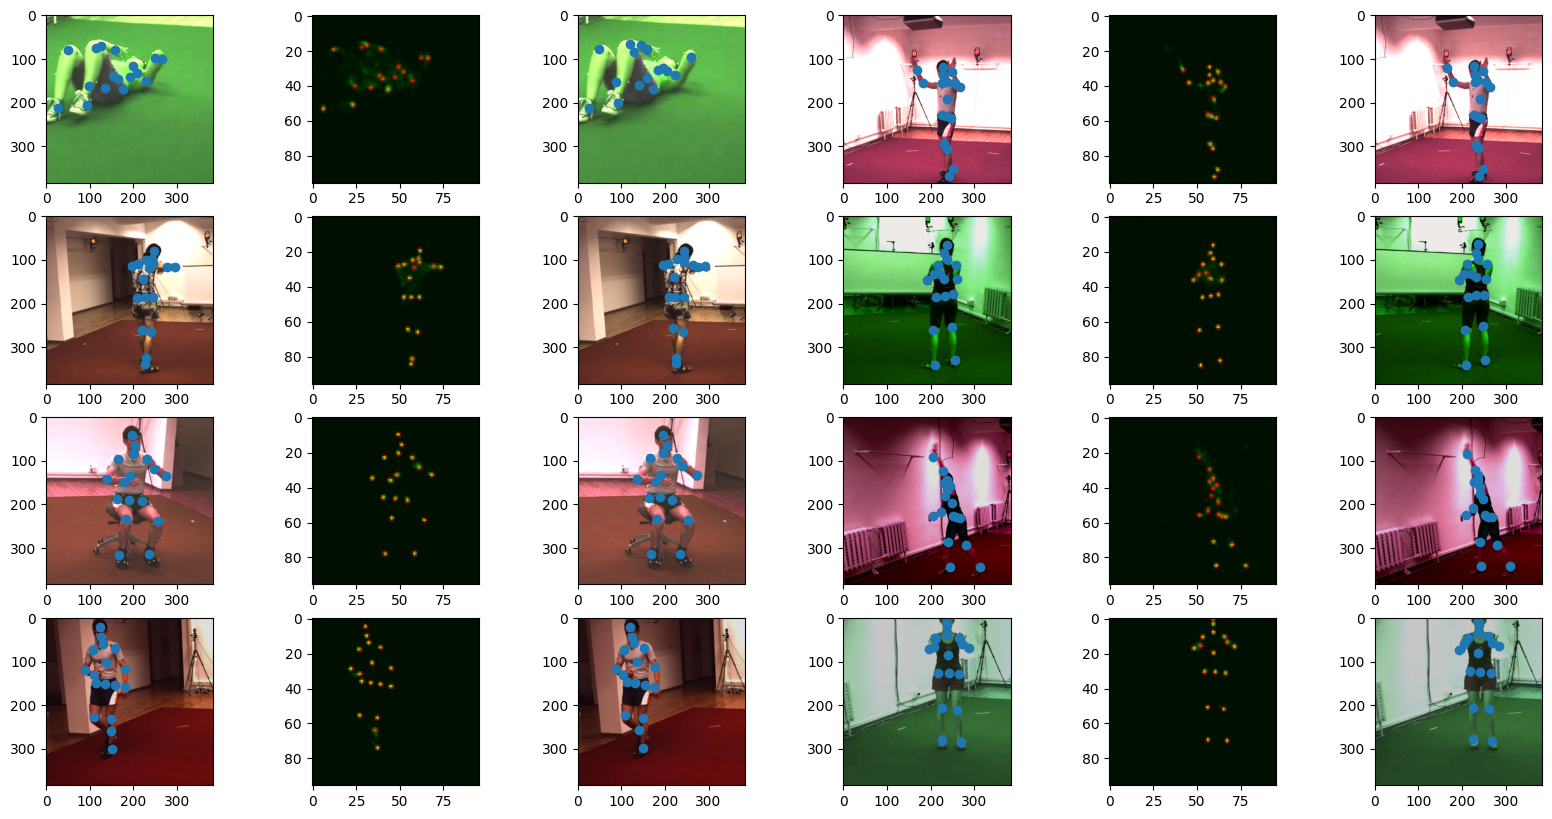

In [5]:
for batch in train_loader:
    for key in batch:
        if key != 'tag':
            batch[key] = batch[key].to(cfg['device']) 
    output, loss ,loss_stats = net(batch)
    break
plt.figure(figsize=(20,10))
for i in range(8):
    plt.subplot(4,6,3*i+1)
    plt.imshow(batch['image'][i].cpu().detach().numpy().transpose([1,2,0])[:,:,::-1])
    x2d = batch['x2d'][i].cpu().detach().reshape(-1,2)
    plt.scatter(x2d[:,0],x2d[:,1])


    # plt.subplot(4,8,2*i+2)
    # plt.imshow(batch['image'][i].cpu().detach().numpy().transpose([1,2,0])[:,:,::-1])
    # x_pred = lds_pred[i].cpu().detach().reshape(-1,2)
    # plt.scatter(x_pred[:,0],x_pred[:,1])
    plt.subplot(4,6,3*i+2)
    plt.imshow(np.stack([
        batch['hm'][i].cpu().detach().numpy().max(axis=0),
        output['hm'][i].cpu().detach().numpy().max(axis=0),
        np.zeros((96,96))
        ],axis=-1))

    plt.subplot(4,6,3*i+3)
    plt.imshow(batch['image'][i].cpu().detach().numpy().transpose([1,2,0])[:,:,::-1])
    pred_x2d = output['pred_x2d'][i].cpu().detach()
    plt.scatter(pred_x2d[:,0],pred_x2d[:,1])

    # for j in range(cfg['num_keypoints']):
    #     plt.text(x3d[j,0],x3d[j,1],str(i))